In [1]:
# # Download a file based on its file ID.
# file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# # Download dataset
# !gdown https://drive.google.com/uc?id={file_id}

# # Unzip the downloaded file
# !unzip -q PlantVillage.zip

## Deep Learning-based Identification & Classification of Brain Tumors from Computerized Tomographic Scans for Portable Devices

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,Activation,LeakyReLU,BatchNormalization,MaxPooling2D,Flatten,Dense,Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer,MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from warnings import filterwarnings
import seaborn as sns


In [3]:
import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer,MultiLabelBinarizer
from sklearn.model_selection import train_test_split


In [4]:
root_dir = r'C:\Users\niran\Desktop\CVR_AI_Comp\Brain_Scan_data'

os.chdir(root_dir)
listdir()

['logs', 'Testing', 'Training']

In [5]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((224, 224))

# Number of images used to train the model
N_IMAGES = 100

training_data_dir = os.path.join(root_dir,'Training')

"""We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above."""

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
print("Load images from all classes ...")
plant_disease_folder_list = listdir(training_data_dir)
print(len(plant_disease_folder_list))

Load images from all classes ...
4


# Loading Training & Validation Data

In [7]:
image_list, label_list = [], []

try:
    print("Loding Image Data ...")
    for s in listdir():
        complete_data_dir = os.path.join(root_dir,s) #C:\Users\niran\Desktop\CVR_AI_Comp\Brain_Scan_data + testing/training

        #List of all the folders inside it
        Brain_Tumor_folders_list = listdir(s)

        for Brain_Tumor_folder in Brain_Tumor_folders_list:
            print(f"Processing  {Brain_Tumor_folder} ...")
            Brain_Tumor_image_list = listdir(f"{complete_data_dir}/{Brain_Tumor_folder}/")

            for image in Brain_Tumor_image_list[:]:
                image_directory = f"{complete_data_dir}/{Brain_Tumor_folder}/{image}"
                if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(Brain_Tumor_folder)

    print("All the images have successfully loaded!!")  
except Exception as e:
    print(f"Error : {e}")

Loding Image Data ...
Processing  test ...
Processing  glioma_tumor ...
Processing  meningioma_tumor ...
Processing  no_tumor ...
Processing  pituitary_tumor ...
Processing  glioma_tumor ...
Processing  meningioma_tumor ...
Processing  no_tumor ...
Processing  pituitary_tumor ...
All the images have successfully loaded!!


In [8]:
len(image_list) 

3264

In [9]:
# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

Total number of images: 3264


# One-Hot Encoding the labels

In [10]:
"""Examine the labels/classes in the training dataset."""

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

# pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  4


In [11]:
tumor_labels = {index:value for index,value in enumerate(label_binarizer.classes_)}
tumor_labels

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

In [12]:
"""# Augment and Split Dataset
Using `ImageDataGenerator` to augment data by performing various operations on the training images.
"""

augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                             fill_mode="nearest")

In [13]:
"""Splitting the data into training and test sets for validation purpose."""

#Shuffling data of training set
idx = np.random.permutation(len(np_image_list))
np_image_list,image_labels = np_image_list[idx], image_labels[idx]

x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.1, random_state = 42)
print('Successfully split data into TRAIN & TEST')


Successfully split data into TRAIN & TEST


In [14]:
"""# Build Model
Defining the hyperparameters of the plant disease classification model.
"""

EPOCHS = 10
STEPS = 100
LR = 0.01 #1e-3
BATCH_SIZE = 32
WIDTH = 224
HEIGHT = 224
DEPTH = 3

"""Creating a Sequential Model to build CNN for multi-class classification"""

model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1



mobilenet = tf.keras.applications.MobileNet(weights= "imagenet", include_top=False, input_shape=inputShape,pooling=max)


# exceptionnet = tf.keras.applications.Xception(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=inputShape,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# ) # Train: 92 Test: 90

# resnet50v2 = tf.keras.applications.ResNet50V2(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=inputShape,
#     pooling=max,
#     classes=1000,
#     classifier_activation="softmax",
# ) # train: 53 test: 58


# model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
# model.add(LeakyReLU(alpha=0.1))
# model.add(BatchNormalization(axis=chanDim))
# model.add(MaxPooling2D(pool_size=(3, 3)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding="same"))
# model.add(LeakyReLU(alpha=0.1))
# model.add(BatchNormalization(axis=chanDim))

# model.add(Conv2D(64, (3, 3), padding="same"))
# model.add(LeakyReLU(alpha=0.1))
# model.add(BatchNormalization(axis=chanDim))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), padding="same"))
# model.add(LeakyReLU(alpha=0.1))
# model.add(BatchNormalization(axis=chanDim))

# model.add(Conv2D(128, (3, 3), padding="same"))
# model.add(LeakyReLU(alpha=0.1))
# model.add(BatchNormalization(axis=chanDim))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(mobilenet)

model.add(Flatten())

model.add(Dense(1024, name = 'my_dense'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# model.add(GlobalAveragePooling2D(name = 'my_dense'))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
my_dense (Dense)             (None, 1024)              51381248  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4

## Feature Extraction from the Dense Layer

In [15]:
layer_name = 'my_dense'
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output) 
intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224_input (In [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
my_dense (Dense)             (None, 1024)              51381248  
Total params: 54,610,112
Trainable params: 54,588,224
Non-trainable params: 21,888
_________________________________________________________________


In [16]:
"""# Train Model
We initialize Adam optimizer with learning rate and decay parameters. 
Also, we choose the type of loss and metrics for the model and compile it for training.
"""
import datetime
# steps_per_epoch=len(x_train) // BATCH_SIZE,

# Initialize optimizer
# opt = Adam(learning_rate=LR, decay=LR / EPOCHS)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD")


#callbacks
# earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30, verbose=1, mode='auto')


#Tensorboard
log_dir= ".\\logs\\test\\"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("Training CNN...")
history = model.fit(augment.flow(x_train, y_train, batch_size=10),
                              validation_data=(x_test, y_test),
                              epochs=15,
                              callbacks = [tensorboard_callback],
                              verbose=1)
        
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")


Training CNN...
Epoch 1/15
294/294 [==============================] - 52s 151ms/step - loss: 0.6282 - accuracy: 0.6983 - val_loss: 0.3802 - val_accuracy: 0.8532
Epoch 2/15
294/294 [==============================] - 43s 145ms/step - loss: 0.4268 - accuracy: 0.8032 - val_loss: 0.2316 - val_accuracy: 0.9021
Epoch 3/15
294/294 [==============================] - 43s 146ms/step - loss: 0.3271 - accuracy: 0.8396 - val_loss: 0.1606 - val_accuracy: 0.9419
Epoch 4/15
294/294 [==============================] - 43s 147ms/step - loss: 0.2721 - accuracy: 0.8587 - val_loss: 0.1371 - val_accuracy: 0.9388
Epoch 5/15
294/294 [==============================] - 44s 148ms/step - loss: 0.2404 - accuracy: 0.8696 - val_loss: 0.1202 - val_accuracy: 0.9450
Epoch 6/15
294/294 [==============================] - 43s 146ms/step - loss: 0.2091 - accuracy: 0.8866 - val_loss: 0.1045 - val_accuracy: 0.9572
Epoch 7/15
294/294 [==============================] - 44s 149ms/step - loss: 0.1917 - accuracy: 0.8996 - val_loss:

In [88]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
# import tensorflow as tf 
# import tensorflow as tf 

# tf.config.list_physical_devices('GPU')

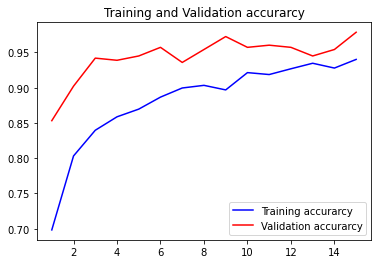

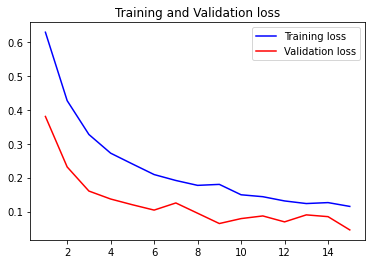

[INFO] Calculating model accuracy
11/11 [==============================] - 2s 168ms/step - loss: 0.0461 - accuracy: 0.9786
Test Accuracy: 97.85932898521423


In [17]:
"""# Evaluate Model
Comparing the accuracy and loss by plotting the graph for training and validation.
"""

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Evaluating model accuracy by using the `evaluate` method"""

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

## Save the model and its weights in .h5 format

In [18]:
#Saving the Model
model.save('MobileNetV1_model.h5')
model.save_weights('MobileNetV1_model_weights.h5')


Save the Intermediate model and its weights in .h5 format

In [19]:
#Saving the Intermediate Model
intermediate_layer_model.save('MobileNetV1_IntermediateModel.h5')
intermediate_layer_model.save_weights('MobileNetV1_IntermediateModel_weights.h5')

In [20]:
#Saving the modle in JSON format
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

IntermediateModel_json = intermediate_layer_model.to_json()
with open("IntermediateModel_json.json", "w") as json_file:
    json_file.write(IntermediateModel_json)


In [21]:
# from tensorflow.keras.models import load_model
# ymodel = load_model(filepath = r'C:\Users\niran\Desktop\CVR_AI_Comp\PDD_completemodel.h5')

x_train_predict = intermediate_layer_model.predict(x_train)
# print(x_train_predict.shape)

x_test_predict = intermediate_layer_model.predict(x_test)
print(x_test_predict.shape)

(327, 1024)


# XGBoost Integration

Integrating the CNN model with Extreme Gradient Boost algorithm.

In [22]:
import xgboost as xgb

xb = xgb.XGBClassifier(use_label_encoder=False)

xb.fit(x_train_predict,np.argmax(y_train,axis=1))

print('XGBoost Fit Complete')

#Save XGBoost Model
# pickle.dump(xb,open('xgb_model.pkl','wb'))

[16:32:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Fit Complete


In [23]:
xb.score(x_train_predict,np.argmax(y_train,axis=1))

1.0

In [24]:
xb.score(x_test_predict,np.argmax(y_test,axis=1))

0.9847094801223242

In [25]:
xb.save_model('mnv1_xgb.json')

In [ ]:
# from tensorflow.keras.models import load_model

# ai = load_model('D:\PDD_Models\HDF5\PDD_Intermediatemodel.h5')
# xgb_model = xgb.XGBClassifier()
# xgb_model.load_model(r'D:\PDD_Models\xgb_model.json')

# x2 = ai.predict(x_test)
# xgb_model.score(x_test_predict,np.argmax(y_test,axis=1))

# Further Scope of Improvement

- Image processing techniques can be implemented before approaching the CNN's input layer
- Developing a Real-Time PDD [Plant Disease Detection] system using Opencv
- Improving the Validation Loss 
- Wider scope of data augmentation & manipulation for better performance
- Integrating CNN with other architectures
- Hyperparameter tunning
- Additional Datasets
- Front End development
- Cross Platform application development 
- Deploying the AI model onto Companion computers for real-time application 

In [ ]:
from tensorflow.keras.models import load_model
mnv1 = load_model(r'C:\Users\niran\Desktop\CVR_AI_Comp\MobileNetV1\MobileNetV1_model.h5')
mnv1.summary()

In [ ]:
history = mnv1.fit(augment.flow(x_train, y_train, batch_size=15),
                              validation_data=(x_test, y_test),
                              epochs=15,
                              verbose=1)

In [35]:
tumor_labels

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

In [58]:
img_path = r'C:\Users\niran\Desktop\CVR_AI_Comp\meningiomaa.jpg'
img_array_list = []
img_array_list.append(convert_image_to_array(img_path))
np_predict_img = np.array(img_array_list, dtype=np.float16) / 255.0
intermodel_prediction = intermediate_layer_model.predict(np_predict_img)
xb_prediction = xb.predict(intermodel_prediction)
print(tumor_labels[list(xb_prediction)[0]]+' has been detected!!')


meningioma_tumor has been detected!!


# Convert saved model to Tensorflow Lite Model

In [63]:
converter = tf.lite.TFLiteConverter.from_saved_model(r'C:\Users\niran\Desktop\CVR_AI_Comp\Brain_Scan_data\Model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('tflite_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [61]:
model.save('Model')

INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets
